In [11]:
import numpy as np
import sys
import os

In [12]:
with open('dataset.txt', 'r') as f:
        raw_data = f.read().lower()
        
data = raw_data.replace("<eos>","\n")

print("Corpus length: %d characters" % len(data))

Corpus length: 1720730 characters


In [9]:
# Visualize sonnet character length
sonnets = data.split('\n\n')
sonnet_lens = [len(sonnet) for sonnet in sonnets]

print('Average sonnet length: %.2f characters' % np.mean(sonnet_lens))



Average sonnet length: 638.63 characters


NameError: name 'plt' is not defined

In [5]:
# Max length of each sequence
maxlen = 45

# Sample new sequence every step characters
step = 3

sentences = []
targets = []

# Loop through sonnets and create sequences and associated targets
for i in range(0, len(data) - maxlen, step):
    sentences.append(data[i:i + maxlen])
    targets.append(data[maxlen + i])

print("Number of sequences:", len(sentences))

# Grab all unique characters in corpus
chars = sorted(list(set(data)))
print("Number of unique characters:", len(chars))

# Dictionary mapping unique character to integer indices
char_indices = dict((char, chars.index(char)) for char in chars)

Number of sequences: 573562
Number of unique characters: 88


In [6]:
# Vectorize sequences and targets
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for j, char in enumerate(sentence):
        x[i, j, char_indices[char]] = 1
    y[i, char_indices[targets[i]]] = 1

print("Size of training sequences:", x.shape)
print("Size of training targets:", y.shape)

Size of training sequences: (573562, 45, 88)
Size of training targets: (573562, 88)


In [7]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               111104    
_________________________________________________________________
dense (Dense)                (None, 88)                11352     
Total params: 122,456
Trainable params: 122,456
Non-trainable params: 0
_________________________________________________________________


In [8]:
from keras.optimizers import SGD

optimizer = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')

The model will output a probability value for each character possible. Instead of choosing the character with the highest probability, we will reweight the probabilities and sample from them based on a "temperature" value. The higher the temperature the more likely a random character will be chosen, the lower the temperature the more deterministic the model will behave.

In [9]:
def sample(preds, temperature=1.0):
    ''' Reweight the predicted probabilities and draw sample from newly created probability distribution. '''
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Now the model will be trained on the text and targets. After training for 1 epoch, a random sequence will be chosen from the training corpus and fed into the model. Using this "seed text" we will predict the next 630 characters at different temperatures and store them in different text files locally.

In [10]:
epochs = 60

loss = []  # Custom history list to save model's loss

# Create directory to store generated text
base_dir = 'generated_text'
if not os.path.isdir(base_dir):
    os.mkdir(base_dir)

for epoch in range(1, epochs+1):
    print("Epoch", epoch)
    # Fit model for 1 epoch then generate text given a seed.
    history = model.fit(x, y, batch_size=128, epochs=1)
    loss.append(history.history['loss'][0])
    
    # Create directory to store text for each epoch
    epoch_dir = os.path.join(base_dir, 'epoch_' + str(epoch))
    if not os.path.isdir(epoch_dir):
        os.mkdir(epoch_dir)
    
    # Select a random seed text to feed into model and generate text
    start_idx = np.random.randint(0, len(data) - maxlen - 1)
    seed_text = data[start_idx:start_idx + maxlen]
    for temp in [0.2, 0.5, 1.0, 1.3]:
        generated_text = seed_text
        temp_file = 'epoch' + str(epoch) + '_temp' + str(temp) + '.txt'
        file = open(os.path.join(epoch_dir, temp_file), 'w')
        file.write(generated_text)
        
        # Predict and generate 600 characters (approx. 1 sonnet length)
        for i in range(630):
            # Vectorize generated text
            sampled = np.zeros((1, maxlen, len(chars)))
            for j, char in enumerate(generated_text):
                sampled[0, j, char_indices[char]] = 1.
            
            # Predict next character
            preds = model.predict(sampled, verbose=0)[0]
            pred_idx = sample(preds, temperature=temp)
            next_char = chars[pred_idx]
            
            # Append predicted character to seed text
            generated_text += next_char
            generated_text = generated_text[1:]
            
            # Write to text file
            file.write(next_char)
        print('Temp ' + str(temp) + " done.")
        file.close()

Epoch 1
2023/4481 [============>.................] - ETA: 2:26 - loss: 2.7771

## Generating New Sonnets
Here we will pick a random seed text from the training data and predict 6330 (average sonnet length) new characters using our newly trained model. We will also use a temperature of 0.5 because that gives a good balance between randomness and deterministic behaviour.

In [5]:
def generate_sonnet(temp):
    ''' Given a temperature, generate a new sonnet '''
    start_idx = np.random.randint(0, len(data) - maxlen - 1)
    new_sonnet = data[start_idx:start_idx + maxlen]
    sys.stdout.write(new_sonnet)
    for i in range(600):
        # Vectorize generated text
        sampled = np.zeros((1, maxlen, len(chars)))
        for j, char in enumerate(new_sonnet):
            sampled[0, j, char_indices[char]] = 1.

        # Predict next character
        preds = model.predict(sampled, verbose=0)[0]
        pred_idx = sample(preds, temperature=temp)
        next_char = chars[pred_idx]

        # Append predicted character to seed text
        new_sonnet += next_char
        new_sonnet = new_sonnet[1:]

        # Print to console
        sys.stdout.write(next_char)
        sys.stdout.flush()

In [7]:
# Generate new sonnets at 0.5 temperature
generate_sonnet(0.5)

NameError: name 'data' is not defined

In [11]:
# Generate new sonnets at 0.2 temperature
generate_sonnet(0.2)

 sake lay on me this cross:
but here's the stree the sweet with the seart,
and the stare the see my see wher the store,
the should the stire the stree the sur thee,
and the still the san the stare the see be the store,
and i st me for me of the stee the sered
my the ere the sor the spee when the seet,
the so the sor more the sere the sweet steee.
the prough the sure the sell in the sell
when the the ere wher hand the sweet shath the see the sered
and the store the sweet wher hath the sered the see the seed
and the stire the seres wher shat thou shat the sere the see the seet steee,
the sor the ser the spore the sure the see,
the sor

In [12]:
# Generate new sonnet with 1.0 temp
generate_sonnet(1.0)

then, dear friend, and i assure ye,
even, he strmins bmire heal ber)eng thou, shagl thou, fedl thou, to may ther's demine,
he race an buwt ghin to thou thow weath repr;sing my fun,
not ha loo hou and owe lovers for eyer dome
the sporce ay more in then to not were piepsent withs owh bres,
whenche for he sable whar beauty; swmer' ariss sthem stall, mar by yfoul,
whore ched othestrus be that whight dooun,
with re bace mone all swill kide sugh and adaradt
hat mis po you leve the noul ancus me mean
beeet fear shelus were)y my nevire the wronkt';;
chence aixe of when gaaguugh and mumi's;
with that you theer is ad of rence pulld,
thy lood,

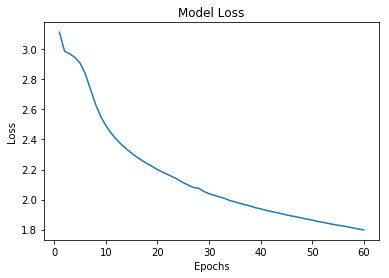

In [16]:
# Plot model loss over epochs
plt.plot([i for i in range(1, epochs+1)], loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

Now we will save the final model for future use.

In [17]:
# Save model
model.save('sonnet_model.h5')